# Predicting Health Insurance Costs

## Introduction

In this project, we are assigned data about health insurance contractors, and we aim to construct a model that could predict a given contractor's insurance charges.

## Exploratory Analysis

To start, we will perform an exploratory analysis on the data. This will help us understand the data, and decide what needs to be done to the data to preprocess it, and what techniques are necessary to build the best model. First, lets' take a look at the data.


In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv("insurance.csv")

display(data.head(n=7))

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
5,31,female,25.740,0,no,southeast,3756.62160
6,46,female,33.440,1,no,southeast,8240.58960


#### The data consists of 7 columns/variables:

- **Age:** The age of the contractor in years expressed as a numerical value.
- **Sex:** The contractor's sex, taking string values as either "male" or "female".
- **BMI:** The contactor's Body Mass Index, which represents the ratio of the body's mass to its height, expressed in numerical values.
- **Children:** Number of dependents of contractors, expressed as a numerical value.
- **Smoker:** Denotes whether the contractor smokes tobacco or not. Expressed in string values of "yes" and "no".
- **Region:** The region within the US where the contractor is. It is expressed in string values of "northeast", "northwest", "southeast", and "southwest".
- **Charges:** The monetary amount that was billed by the health insurance company, expressed in a numerical value.

Next, we will visualize the data so we can better understand it and each of its features.

In [46]:
#data.replace({})
#data = data.replace(['yes','no'], [1,0])

(array([574.,   0., 324.,   0., 240.,   0., 157.,   0.,  25.,  18.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <a list of 10 Patch objects>)

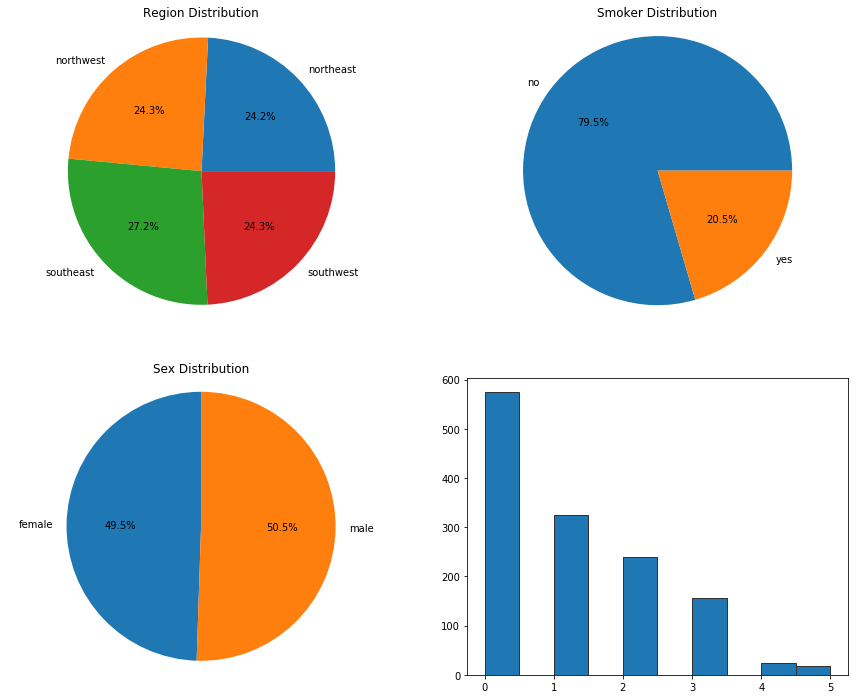

In [85]:
fig1, ((ax11,ax12),(ax13,ax14)) = plt.subplots(2,2)
fig1.set_size_inches(15,12)
regionsizes = data.groupby("region").size().values
regionlabels = data.groupby('region').size().keys()

sexsizes = data.groupby("sex").size().values
sexlabels = data.groupby('sex').size().keys()

smokesizes = data.groupby("smoker").size().values
smokelabels = data.groupby('smoker').size().keys()

ax11.pie(regionsizes, labels=regionlabels, autopct='%1.1f%%')
ax11.set_title("Region Distribution")
ax11.axis('equal')

ax13.pie(sexsizes, labels=sexlabels, autopct='%1.1f%%', startangle=90)
ax13.set_title("Sex Distribution")
ax13.axis('equal')

ax12.pie(smokesizes, labels=smokelabels, autopct="%1.1f%%")
ax12.set_title("Smoker Distribution")
ax12.axis('equal')

ax14.hist('children', data=data,edgecolor =' 0.2')

The contractors are divided between the 4 regions nearly equally, and are also split between the two sexes equally, as shown in the two pie charts on the left. The majority of contractors are non-smokers, and it is evident that contractors without children dominate, while the frequency decreases as the number of children goes up.

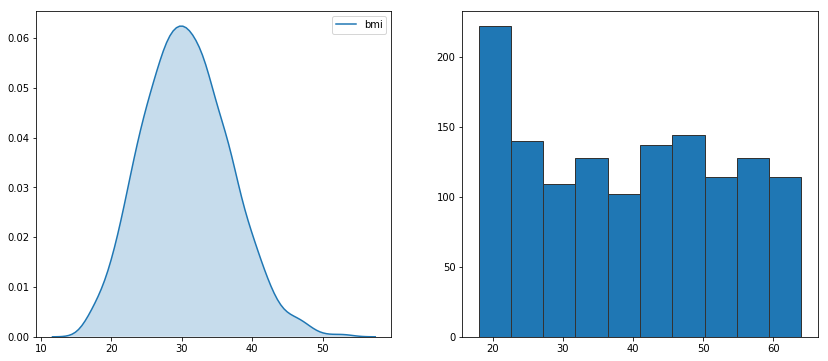

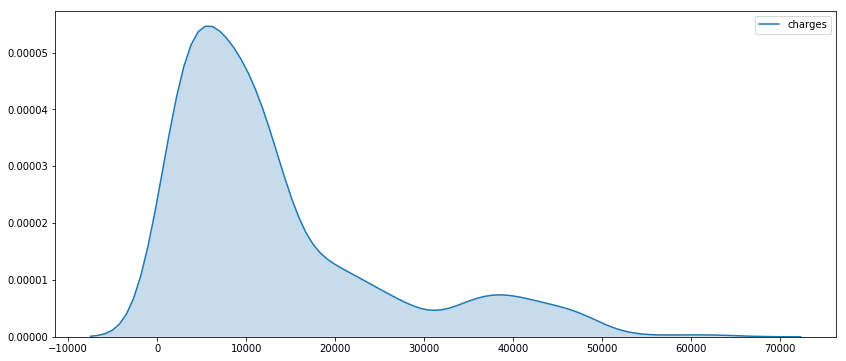

In [87]:
fig21, (ax21,ax22) = plt.subplots(1,2)
fig21.set_size_inches(14,6)

sns.kdeplot(data['bmi'], ax=ax21, shade=True)
ax22.hist('age', data=data, bins=10, edgecolor='0.2')

fig22, ax23 = plt.subplots()
fig22.set_size_inches(14,6)
sns.kdeplot(data['charges'], ax=ax23, shade=True)

- The BMI distribution is bell-shaped and symmetrical
- The Age distribution is mostly uniform, except for ages below 25 where the histogram peaks.
- The charges distribution is skewed to the left.

Left skewness is typical of monetary distributions. A logarithmic transformation is often useful for such distributions, and particularly monetary distributions, given that money values tend to be thought of as multiplicative more=so than additive. For example, a $100 difference between $50,100 and $50,000 might seem insignificant, whereas the same difference between $150 and $250 is not.

The feature of interest is the **charges** feature. Let's examine the effect of categorical features on the distribution of billed charges. The categorical features are: Region, Sex, abd Smoker. We will also treat the "children" feature as categorical and examine it in the same manner, because it only has 6 values.

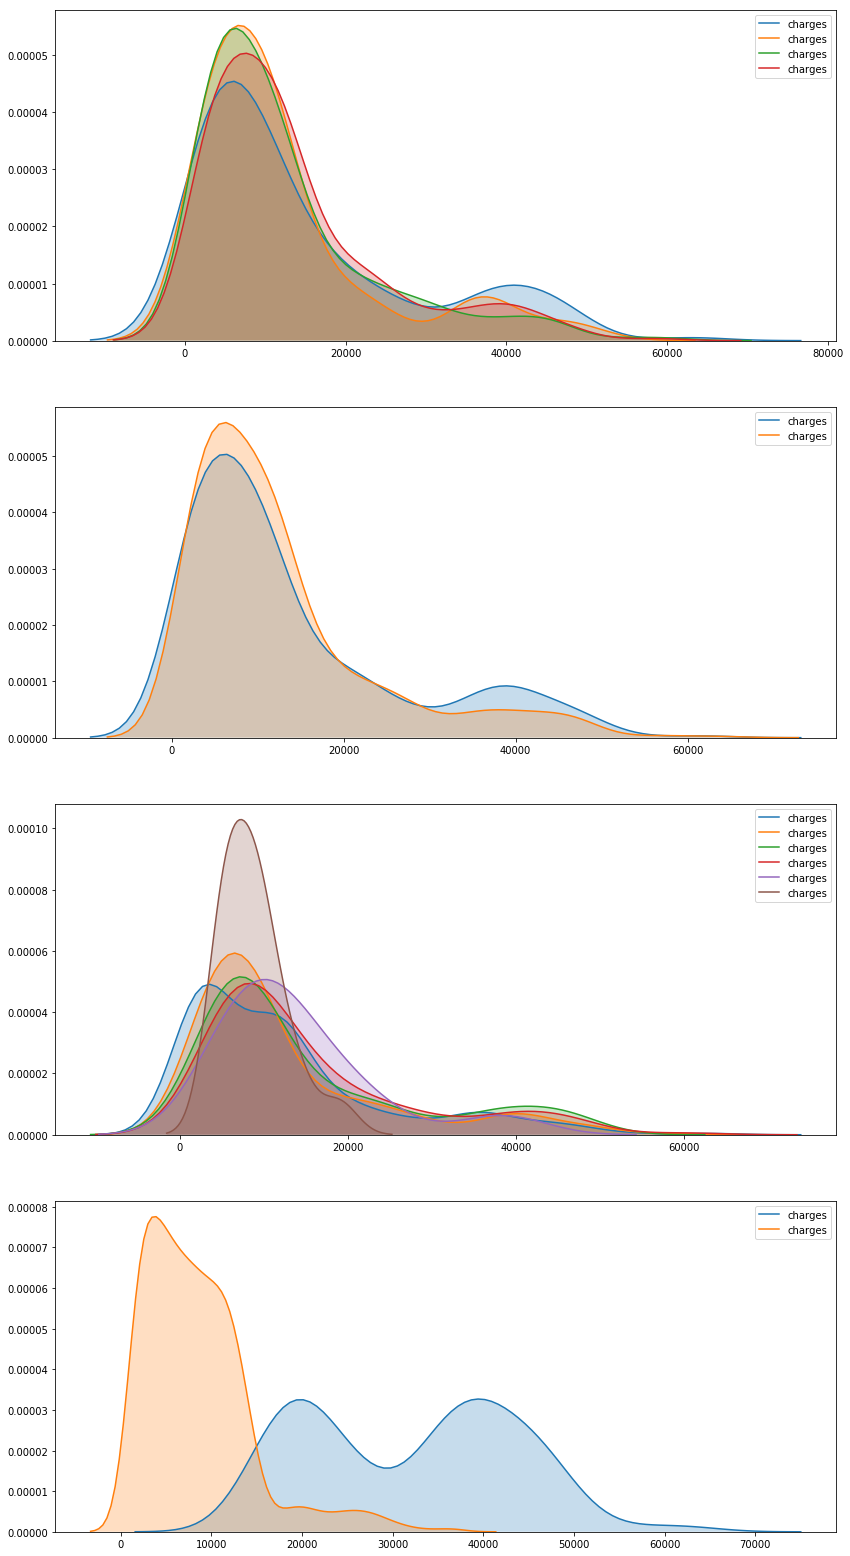

In [105]:
fig3, (ax31,ax32,ax33,ax34) = plt.subplots(4,1)
fig3.set_size_inches(14,28)
sns.kdeplot(data.loc[data["region"] == 'southeast']["charges"], ax=ax31, shade=True)
sns.kdeplot(data.loc[data["region"] == 'southwest']["charges"], ax=ax31, shade=True)
sns.kdeplot(data.loc[data["region"] == 'northwest']["charges"], ax=ax31, shade=True)
sns.kdeplot(data.loc[data["region"] == 'northeast']["charges"], ax=ax31, shade=True)
ax3.set_ylabel("Frequency")

sns.kdeplot(data.loc[data["sex"] == 'male']["charges"], ax=ax32, shade=True)
sns.kdeplot(data.loc[data["sex"] == 'female']["charges"], ax=ax32, shade=True)

sns.kdeplot(data.loc[data["children"] == 0]["charges"], ax=ax33, shade=True)
sns.kdeplot(data.loc[data["children"] == 1]["charges"], ax=ax33, shade=True)
sns.kdeplot(data.loc[data["children"] == 2]["charges"], ax=ax33, shade=True)
sns.kdeplot(data.loc[data["children"] == 3]["charges"], ax=ax33, shade=True)
sns.kdeplot(data.loc[data["children"] == 4]["charges"], ax=ax33, shade=True)
sns.kdeplot(data.loc[data["children"] == 5]["charges"], ax=ax33, shade=True)

sns.kdeplot(data.loc[data["smoker"] == 'yes']["charges"], ax=ax34, shade=True)
sns.kdeplot(data.loc[data["smoker"] == 'no']["charges"], ax=ax34, shade=True)


e:\python27\lib\site-packages\seaborn\regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
e:\python27\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


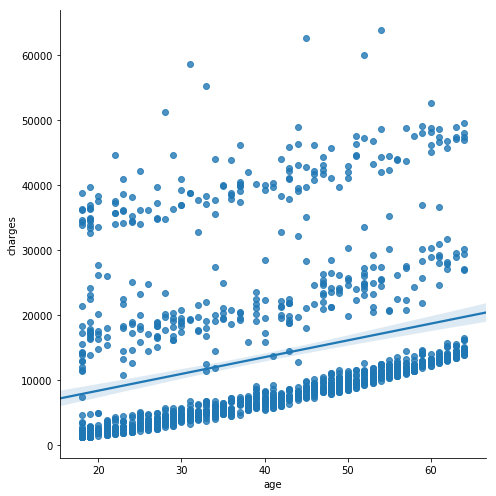

In [50]:
sns.lmplot("age", "charges", data, size=7)

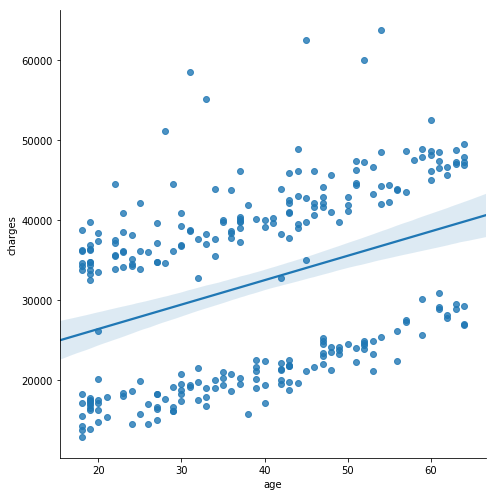

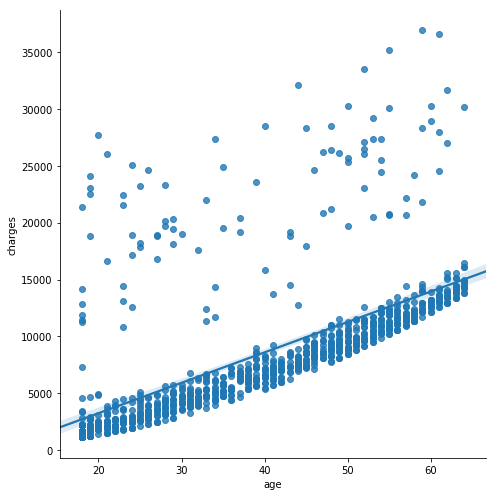

In [114]:
sns.lmplot("age", "charges", smoker_data, size = 7)
sns.lmplot("age", "charges", nonsmoker_data, size = 7)

In [135]:
display(smoker_data.loc[smoker_data["charges"] > 30000].groupby("sex").count())
display(data.groupby("sex").count())

,age,bmi,children,smoker,region,charges
sex,,,,,,
female,54,54,54,54,54,54
male,98,98,98,98,98,98


,age,bmi,children,smoker,region,charges
sex,,,,,,
female,662,662,662,662,662,662
male,676,676,676,676,676,676


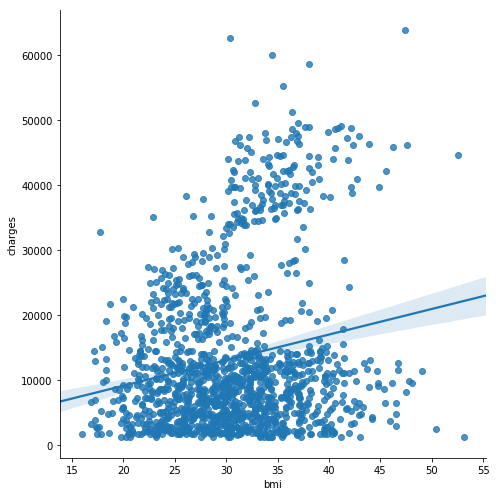

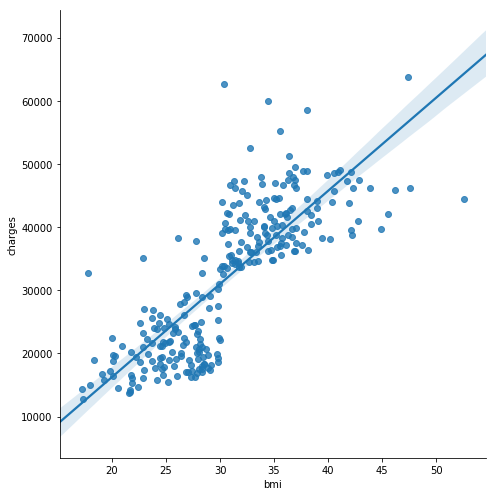

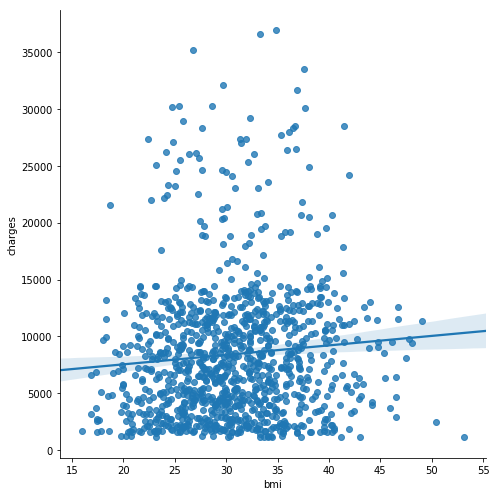

In [137]:
sns.lmplot("bmi", "charges", data, size=7)
sns.lmplot("bmi", "charges", smoker_data, size = 7)
sns.lmplot("bmi", "charges", nonsmoker_data, size = 7)

In [227]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

X = data.drop(['charges','sex','region','children'], axis=1)
Y = data["charges"]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)



X_s_train = X_test.loc[X_test['smoker'] == 'yes'].drop('smoker', axis=1)
X_n_train = X_test.loc[X_test['smoker'] == 'no'].drop(['smoker','bmi'], axis=1)
Y_s_train = Y_test.loc[X_test['smoker'] == 'yes']
Y_n_train = Y_test.loc[X_test['smoker'] == 'no']


smokermodel = LinearRegression()
smokermodel.fit(X_s_train,Y_s_train)
nonsmokermodel = LinearRegression()
nonsmokermodel.fit(X_n_train,Y_n_train)
print(X_train.columns)
def predictor(df):
    smokers = df[df['smoker']=='yes']
#     display(smokers)
    non_smokers = df[df['smoker']=='no']
    smokers['prediction'] = smokermodel.predict(smokers[['age','bmi']])
    non_smokers['prediction']= nonsmokermodel.predict(non_smokers[['age']])
    frames = [smokers, non_smokers]
    return  pd.concat(frames)

predictions_combined_df = predictor(X_test[['age','bmi','smoker']])
display(X_test.head())
predictions_combined_df.head()
# print("Accuracy score")
# print(r2_score(predictions_combined_df['prediction'].values,Y_test))

e:\python27\lib\site-packages\pandas\core\ops.py:1167: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


TypeError: invalid type comparison

In [231]:
from sklearn.tree import DecisionTreeRegressor
clf = DecisionTreeRegressor(max_depth=10,min_samples_split=3,max_leaf_nodes=10)
clf.fit(X_train,Y_train)
predictions = clf.predict(X_test)
r2_score(predictions,Y_test)

0.8229919756015871

In [84]:

feats = {}
for feature, importance in zip(feature.columns, clf.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance',ascending=False).plot(kind='bar', rot=45)
print(importances.sort_values(by='Gini-importance',ascending=False))
plt.show()

NameError: name 'features' is not defined

In [81]:
import pydotplus
graph = pydotplus.graph_from_dot_data(dot_data)
colors = ( 'forestgreen','brown')
edges = collections.defaultdict(list)
for edge in graph.get_edge_list():
    edges[edge.get_source()].append(int(edge.get_destination()))

for edge in edges:
    edges[edge].sort()    
    for i in range(2):
        dest = graph.get_node(str(edges[edge][i]))[0]
        
        dest.set_fillcolor(colors[i])
        

graph.write_png('tree.png')
# display(SVG(graph.pipe(format='svg')))
display(Image(filename='./tree.png'))

NameError: name 'dot_data' is not defined